In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

In [2]:
def one_hot_encode_smiles(smiles, charset, max_length=120):
    char_to_int = dict((c, i) for i, c in enumerate(charset))
    integer_encoded = [char_to_int[char] for char in smiles]
    if len(integer_encoded) > max_length:
        integer_encoded = integer_encoded[:max_length]
    else:
        integer_encoded = integer_encoded + [0] * (max_length - len(integer_encoded))
    onehot_encoded = np.zeros((max_length, len(charset)), dtype=np.float32)
    for i, val in enumerate(integer_encoded):
        onehot_encoded[i, val] = 1.0

    return onehot_encoded

In [3]:
def decode_smiles_from_one_hot(one_hot_encoded, charset):
    int_to_char = {i: c for i, c in enumerate(charset)}
    integer_decoded = np.argmax(one_hot_encoded, axis=1)
    chars = [int_to_char[idx] for idx in integer_decoded]
    smiles = ''.join(chars).rstrip()

    return smiles

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

class MolecularVAE(nn.Module):
    def __init__(self):
        super(MolecularVAE, self).__init__()

        self.conv_1 = nn.Conv1d(120, 9, kernel_size=9)
        self.conv_2 = nn.Conv1d(9, 9, kernel_size=9)
        self.conv_3 = nn.Conv1d(9, 10, kernel_size=11)
        self.linear_0 = nn.Linear(90, 435)
        self.linear_1 = nn.Linear(435, 292)
        self.linear_2 = nn.Linear(435, 292)

        self.linear_3 = nn.Linear(292, 292)
        self.gru = nn.GRU(292, 501, 3, batch_first=True)
        self.linear_4 = nn.Linear(501, 35)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()

    def encode(self, x):
        x = self.relu(self.conv_1(x))
        x = self.relu(self.conv_2(x))
        x = self.relu(self.conv_3(x))
        x = x.view(x.size(0), -1)
        x = F.selu(self.linear_0(x))
        return self.linear_1(x), self.linear_2(x)

    def sampling(self, z_mean, z_logvar):
        epsilon = 1e-2 * torch.randn_like(z_logvar)
        return torch.exp(0.5 * z_logvar) * epsilon + z_mean

    def decode(self, z):
        z = F.selu(self.linear_3(z))
        z = z.view(z.size(0), 1, z.size(-1)).repeat(1, 120, 1)
        output, hn = self.gru(z)
        out_reshape = output.contiguous().view(-1, output.size(-1))
        y0 = F.softmax(self.linear_4(out_reshape), dim=1)
        y = y0.contiguous().view(output.size(0), -1, y0.size(-1))
        return y

    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.sampling(z_mean, z_logvar)
        return self.decode(z), z_mean, z_logvar

In [5]:
model = MolecularVAE()
checkpoint = torch.load('/content/drive/MyDrive/checkpoints/checkpoint_epoch_60.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MolecularVAE(
  (conv_1): Conv1d(120, 9, kernel_size=(9,), stride=(1,))
  (conv_2): Conv1d(9, 9, kernel_size=(9,), stride=(1,))
  (conv_3): Conv1d(9, 10, kernel_size=(11,), stride=(1,))
  (linear_0): Linear(in_features=90, out_features=435, bias=True)
  (linear_1): Linear(in_features=435, out_features=292, bias=True)
  (linear_2): Linear(in_features=435, out_features=292, bias=True)
  (linear_3): Linear(in_features=292, out_features=292, bias=True)
  (gru): GRU(292, 501, num_layers=3, batch_first=True)
  (linear_4): Linear(in_features=501, out_features=35, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=None)
)

In [6]:
df = pd.read_csv("250k_rndm_zinc_drugs_clean_3.csv")
df["smiles"] = df["smiles"].str.rstrip("\n")

In [7]:
df.head()

,smiles,logP,qed,SAS
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,5.05060,0.702012,2.084095
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,3.11370,0.928975,3.432004
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,4.96778,0.599682,2.470633
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,4.00022,0.690944,2.822753
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,3.60956,0.789027,4.035182


In [8]:
charset = set("".join(df["smiles"].values.tolist()))
charset = sorted(list(charset))
charset.insert(0, " ")

In [9]:
len(charset)

35

In [10]:
encoded_smiles = one_hot_encode_smiles(df.loc[0, "smiles"], charset)
output, mean, logvar = model(torch.tensor([encoded_smiles]))
output_smiles = decode_smiles_from_one_hot(output[0].detach().cpu().numpy(), charset)

<ipython-input-10-77919a5174eb>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  output, mean, logvar = model(torch.tensor([encoded_smiles]))


In [12]:
output_smiles

'CC(C)(C)c1ccc22cc(CC(=O)Nc3ccccc3F)ccc1'

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
sampled = df.sample(2000)
batch_size = 128
results = []

for i in range(0, len(sampled), batch_size):
    batch = sampled.iloc[i:i+batch_size]

    encoded_batch = [one_hot_encode_smiles(smiles, charset) for smiles in batch["smiles"]]
    encoded_tensor = torch.tensor(encoded_batch).to(device)

    with torch.no_grad():
        output, mean, logvar = model(encoded_tensor)

    output_smiles = [decode_smiles_from_one_hot(out.cpu().numpy(), charset) for out in output]

    batch_results = pd.DataFrame({
        "generated_smiles": output_smiles,
        **{f"mean_{i}": mean.cpu().numpy()[:, i] for i in range(mean.shape[1])},
        **{f"logvar_{i}": logvar.cpu().numpy()[:, i] for i in range(logvar.shape[1])}
    }, index=batch.index)

    results.append(batch_results)

result = pd.concat(results)
sampled = pd.concat([sampled, result], axis=1)

In [15]:
sampled.head()

,smiles,logP,qed,SAS,generated_smiles,mean_0,mean_1,mean_2,mean_3,mean_4,...,logvar_282,logvar_283,logvar_284,logvar_285,logvar_286,logvar_287,logvar_288,logvar_289,logvar_290,logvar_291
245737,C[C@H]1CC(=Cc2ccco2)[C@H](C)[NH+](C)C1,1.6060,0.745139,4.953414,C[C@H]1CC(C(c2cccc2)[C@H](C)[N33+]CCC1,0.005475,0.010553,-0.005000,0.001619,0.012531,...,-0.004345,0.004265,-0.000581,-0.002295,0.008299,0.004372,-0.036388,0.000180,0.001363,-0.047771
79473,Cn1nccc1CNC(=O)NCC(C)(C)[NH+]1CCc2ccccc2C1,0.6391,0.760290,3.937398,Cn1nccc1CNC(=O)NCC(C)(C)[NH+]1CCc2ccccc2C1,-0.002260,0.002274,0.014162,-0.009262,0.003959,...,0.000515,0.001874,-0.000917,0.001083,-0.002063,0.004382,-0.020915,0.000428,0.003548,-0.018232
182100,C[C@@H](NC(=O)C[C@@H](O)c1cccc(F)c1)c1cccc(F)c1F,3.4048,0.868086,2.888081,C[C@@H](NC(=O)C[C@@H](O)c1cccc(F)c1)c1ccc(F)cc1F,0.016426,0.010108,0.011163,-0.010729,-0.015268,...,-0.001588,-0.006616,0.005970,0.001440,0.003667,0.001347,-0.031894,-0.000176,-0.001200,-0.052208
231994,O=C(Cn1c(=O)c2sccc2n(CC(=O)Nc2ccccc2)c1=O)NCc1...,1.7728,0.459699,2.325653,O=C1Cn2c(=O)cc2cccs2)CC(=O)N(2ccccc22)CC1))c1c...,-0.026035,-0.014700,0.018184,-0.001226,-0.013198,...,0.005659,0.005857,0.000746,0.005020,-0.001026,0.008211,-0.000338,0.003715,0.000623,-0.048039
7022,O=C1C[C@H]([NH+]2CCOCC2)C=C1Nc1ccccc1,0.2389,0.836824,4.280132,O=C1C[C@H]([NH+]2CC2CC2CC2=NNc1ccccc1,-0.012433,0.010592,0.002076,0.014806,-0.023776,...,-0.005521,0.002094,-0.002721,0.002855,0.010124,0.004138,0.002415,0.003087,0.002962,-0.054548


In [16]:
num_valid_smiles = (sampled['smiles'] == sampled['generated_smiles']).sum()
print(f"Num samples: {len(sampled)}")
print(f"Successglly decoded smiles: {num_valid_smiles}")
print(f"Successfull rate: {num_valid_smiles/len(sampled)}")

Num samples: 2000
Successglly decoded smiles: 190
Successfull rate: 0.095


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [18]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.8 MB/s eta 0:00:00


In [19]:
from sklearn.manifold import TSNE
from umap import UMAP
import numpy as np

X = sampled.loc[:, sampled.columns.str.startswith("mean")]
n_components = 2
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

umap = UMAP(n_components=2, random_state=42)
X_umap = umap.fit_transform(X)

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


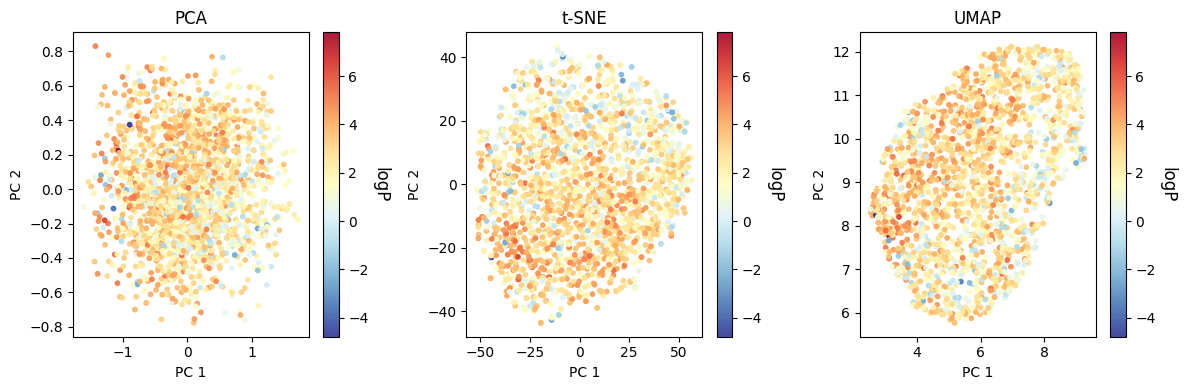

In [31]:
reductions = {
    "PCA": X_pca,
    "t-SNE": X_tsne,
    "UMAP": X_umap
}

fig = plt.figure(figsize=(12,4))
for i, (name, X_reduced) in enumerate(reductions.items()):
  ax = fig.add_subplot(1, 3, i+1)
  scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], s=10, alpha=0.9, c=sampled["logP"], cmap="RdYlBu_r")
  cbar = plt.colorbar(scatter)
  cbar.set_label('logP', rotation=270, labelpad=15, fontsize=12)
  ax.set_xlabel("PC 1")
  ax.set_ylabel("PC 2")
  ax.set_title(name)
plt.tight_layout()
plt.show()

In [21]:
latent_vector = torch.randn(1000, 292)
generated_ohe = model.decode(latent_vector)

In [22]:
generated_ohe.shape

torch.Size([1000, 120, 35])

In [23]:
generated_smiles = [decode_smiles_from_one_hot(ohe.detach().cpu().numpy(), charset) for ohe in generated_ohe]

In [24]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 25.5 MB/s eta 0:00:00


In [25]:
from rdkit import Chem
valid_smiles = []
for smi in generated_smiles:
  if Chem.MolFromSmiles(smi) is not None:
    valid_smiles.append(smi)

[23:55:08] SMILES Parse Error: syntax error while parsing: ===Nc1r(B(()))=)(N((()(())(C)CCC
[23:55:08] SMILES Parse Error: Failed parsing SMILES '===Nc1r(B(()))=)(N((()(())(C)CCC' for input: '===Nc1r(B(()))=)(N((()(())(C)CCC'
[23:55:08] SMILES Parse Error: syntax error while parsing: CCCCCC@@]))nnnnn())N+CC))nnc))n1
[23:55:08] SMILES Parse Error: Failed parsing SMILES 'CCCCCC@@]))nnnnn())N+CC))nnc))n1' for input: 'CCCCCC@@]))nnnnn())N+CC))nnc))n1'
[23:55:08] SMILES Parse Error: syntax error while parsing: CCCCCCCH](C[NHH]CCCNCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn
[23:55:08] SMILES Parse Error: Failed parsing SMILES 'CCCCCCCH](C[NHH]CCCNCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn' for input: 'CCCCCCCH](C[NHH]CCCNCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnnn'
[23:55:08] SMILES Parse Error: syntax error while parsing:

In [26]:
valid_smiles

['CCOCC\\CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC',
 'PCP P---+)))))CCC',
 'CCSSSSS']

In [27]:
mols = [Chem.MolFromSmiles(smi) for smi in valid_smiles]

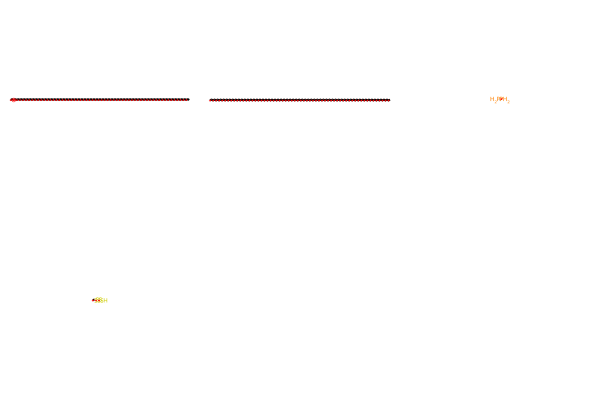

In [28]:
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols, molsPerRow=3)